# FI-2Pop demo

Demo notebook on the integration of FI-2Pop with the L-System.

## Imports

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, axis_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions

## Setup

In [4]:
# import logging

# logging.basicConfig()
# logger = logging.getLogger('base-logger')
# logger.setLevel(logging.WARNING)

In [5]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

In [6]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

In [7]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

# for k in block_definitions.keys():
#     if k != "":  # TODO: This is a probable bug, reported to the SE API devs
#         ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

In [8]:
used_ll_blocks = [
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCornerInv',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCorner',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorSlope',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorBlock',
    'MyObjectBuilder_Gyro_LargeBlockGyro',
    'MyObjectBuilder_Reactor_LargeBlockSmallGenerator',
    'MyObjectBuilder_CargoContainer_LargeBlockSmallContainer',
    'MyObjectBuilder_Cockpit_OpenCockpitLarge',
    'MyObjectBuilder_Thrust_LargeBlockSmallThrust',
    'MyObjectBuilder_InteriorLight_SmallLight',
    'MyObjectBuilder_CubeBlock_Window1x1Slope',
    'MyObjectBuilder_CubeBlock_Window1x1Flat',
    'MyObjectBuilder_InteriorLight_LargeBlockLight_1corner'
]

for k in used_ll_blocks:
    ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## L-System components

In [9]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

In [10]:
rcc1 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc1.extra_args["req_tiles"] = ['cockpit']

rcc2 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc2.extra_args["req_tiles"] = ['corridorcargo', 'corridorgyros', 'corridorreactors']

rcc3 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc3.extra_args["req_tiles"] = ['thrusters']

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

# ax = ConstraintHandler(
#     name="axis1",
#     level=ConstraintLevel.SOFT_CONSTRAINT,
#     when=ConstraintTime.END,
#     f=axis_constraint,
#     extra_args={
#         'alphabet': dict(hl_alphabet, **ll_alphabet)
#     },
#     needs_ll=True
# )

In [11]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver, names=['HeadModule', 'BodyModule', 'TailModule']
)

In [12]:
lsystem.add_hl_constraints(cs=[
    [nic, rcc1],
    [nic, rcc2],
    [nic, rcc3]
])

lsystem.add_ll_constraints(cs=[
    [sc],
    [sc],
    [sc]
])

In [13]:
from pcgsepy.evo.genops import expander

expander.initialize(rules=lsystem.hl_solver.parser.rules)

## Experiments

In [14]:
from pcgsepy.config import N_RUNS, EXP_NAME

run_experiment = True

In [15]:
from pcgsepy.evo.fitness import box_filling_fitness, func_blocks_fitness, mame_fitness, mami_fitness

fitnesses = [box_filling_fitness,
             func_blocks_fitness,
             mame_fitness,
             mami_fitness]

In [16]:
import numpy as np
from pcgsepy.lsystem.solution import CandidateSolution
from pcgsepy.config import BBOX_X, BBOX_Y, BBOX_Z, POP_SIZE
from pcgsepy.evo.fitness import futo_es, futo_max, tovo_es, tovo_max, mame_es, mame_max, mami_es, mami_max

def save_stats(cs: CandidateSolution,
               exp_name: str = EXP_NAME) -> None:
    # structure = cs.content
    
    # x, y, z = structure.as_array().shape
    # bbox = np.clip((BBOX_X - abs(BBOX_X - x)) / BBOX_X, 0, 1)
    # bbox += np.clip((BBOX_Y - abs(BBOX_Y - y)) / BBOX_Y, 0, 1)
    # bbox += np.clip((BBOX_Z - abs(BBOX_Z - z)) / BBOX_Z, 0, 1)
    # bbox /= 3
    
    # functional_blocks_volume, filled_volume = 0., 0.
    # for b in structure._blocks.values():
    #     if not b.block_type.startswith('MyObjectBuilder_CubeBlock_'):
    #         functional_blocks_volume += b.volume
    #     filled_volume += b.volume

    # total_volume = structure.as_array().shape
    # total_volume = total_volume[0] * total_volume[1] * total_volume[2]

    # futo = functional_blocks_volume / (functional_blocks_volume + filled_volume)
    # tovo = (functional_blocks_volume + filled_volume) / total_volume
    # volume = functional_blocks_volume + filled_volume

    # total_volume = structure.as_array().shape
    # largest_axis, medium_axis, smallest_axis = reversed(sorted(list(total_volume)))
    # mame = largest_axis / medium_axis
    # mami = largest_axis / smallest_axis

    # futo_f = futo_es.evaluate(futo) / futo_max
    # tovo_f = tovo_es.evaluate(tovo) / tovo_max
    # mame_f = mame_es.evaluate(mame) / mame_max
    # mami_f = mami_es.evaluate(mami)/ mami_max
    
    with open(f'{exp_name}_atoms.log', 'a') as f:
        f.write(f'\n\n{cs.string}')
        for fitness, v in zip(fitnesses, cs.fitness):
            f.write(f'\n{fitness.__name__}: {v}')
        # f.write(f'\nVolume: {volume}')
        # f.write(f'\nBBox: {(x, y, z)} ({bbox})')
        # f.write(f'\nFunctional blocks / total blocks = {futo} ({futo_f})')
        # f.write(f'\nFilled volume / total volume = {tovo} ({tovo_f})')
        # f.write(f'\nLargest axis / Medium axis = {mame} ({mame_f})')
        # f.write(f'\nLargest axis / Medium axis = {mami} ({mami_f})')

In [17]:
from tqdm.notebook import trange
import numpy as np
import random
from pcgsepy.fi2pop.lgp import LGPSolver
from pcgsepy.fi2pop.fi2pop import FI2PopSolver
from pcgsepy.config import N_RETRIES, N_GENS

def run_experiment(solver,
                   exp_name,
                   seeds,
                   pops_size: int = POP_SIZE,
                   n_retries: int = N_RETRIES):
    f_fitnesses_hist = []
    i_fitnesses_hist = []
    elite_f_fitnesses = []
    with trange(N_RUNS, desc='Running experiments') as iterations:
        for n in iterations:
            np.random.seed(seeds[n])
            random.seed(seeds[n])
            solver.reset()         
            f_pop, i_pop = solver.initialize(pops_size=pops_size,
                                             n_retries=n_retries)
            f_pop, i_pop = solver.fi2pop(f_pop=f_pop,
                                         i_pop=i_pop,
                                         n_iter=N_GENS)
            f_fitnesses_hist.append(solver.ffs)
            i_fitnesses_hist.append(solver.ifs)
            f_fitnesses = [cs.c_fitness for cs in f_pop]
            i_fitnesses = [cs.ncv for cs in f_pop]
            elite = f_pop[f_fitnesses.index(max(f_fitnesses))]
            save_stats(cs=elite,
                       exp_name=exp_name)
            elite_f_fitnesses.append(elite.fitness)
            iterations.set_postfix(ordered_dict={'f_fit': np.max(f_fitnesses),
                                                 'i_fit': np.min(i_fitnesses)},
                                   refresh=True)
    return f_fitnesses_hist, i_fitnesses_hist, elite_f_fitnesses

def save_metrics(f_fitnesses_hist,
                 i_fitnesses_hist,
                 exp_name):
    ffs = np.empty(shape=(N_RUNS, 1 + N_GENS, 2))
    for r, rv in enumerate(f_fitnesses_hist):
        for g, gv in enumerate(rv):
            ffs[r, g, :] = gv
    ifs = np.empty(shape=(N_RUNS, 1 + N_GENS, 2))
    for r, rv in enumerate(i_fitnesses_hist):
        for g, gv in enumerate(rv):
            ifs[r, g, :] = gv
    with open(f'results/{exp_name}_metrics.npz', 'wb') as f:
        np.savez(f, ffs, ifs)

def save_elite_metrics(elite_f_fitnesses,
                       exp_name):
    efs = np.empty(shape=(N_RUNS, 4))
    for r, v in enumerate(elite_f_fitnesses):
        efs[r, :] = v
    with open(f'results/{exp_name}_elites.npz', 'wb') as f:
        np.savez(f, efs)
    

if run_experiment:
    seeds = [42, 3312022, 12345, 98765, 0]
    
    print(f'Running {N_RUNS} experiments with LGP...')
    solver = LGPSolver(alphabet=hl_alphabet,
                       feasible_fitnesses=fitnesses,
                       lsystem=lsystem)
    solver.inner_lgp_iterations = 5
    f_fitnesses_hist, i_fitnesses_hist, elite_f_fitnesses = run_experiment(solver=solver,
                                                                           exp_name='lgp_baseline',
                                                                           seeds=seeds,
                                                                           n_retries=500)
    save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                 i_fitnesses_hist=i_fitnesses_hist,
                 exp_name='lgp_baseline')
    save_elite_metrics(elite_f_fitnesses=elite_f_fitnesses,
                       exp_name='lgp_baseline')
    
    print(f'Running {N_RUNS} experiments with HybridEA...')
    solver = FI2PopSolver(feasible_fitnesses=fitnesses,
                          lsystem=lsystem)
    f_fitnesses_hist, i_fitnesses_hist, elite_f_fitnesses = run_experiment(solver=solver,
                                                                           exp_name='hybrid_ea',
                                                                           seeds=seeds)
    save_metrics(f_fitnesses_hist=f_fitnesses_hist,
                 i_fitnesses_hist=i_fitnesses_hist,
                 exp_name='hybrid_ea')
    save_elite_metrics(elite_f_fitnesses=elite_f_fitnesses,
                       exp_name='hybrid_ea')

Running 5 experiments with LGP...


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Initialization :   0%|          | 0/500 [00:00<?, ?it/s]

Created Feasible population of size 17: t:2.974743745085483;m:1.4079310504756812
Created Infeasible population of size 20: t:1;m:1.75


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Initialization :   0%|          | 0/500 [00:00<?, ?it/s]

Created Feasible population of size 18: t:2.3898155382566904;m:1.3780460623676805
Created Infeasible population of size 20: t:1;m:1.7


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Initialization :   0%|          | 0/500 [00:00<?, ?it/s]

Created Feasible population of size 6: t:1.8261203684449003;m:1.279510003700766
Created Infeasible population of size 20: t:1;m:1.75


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Initialization :   0%|          | 0/500 [00:00<?, ?it/s]

Created Feasible population of size 17: t:1.9774951487470769;m:1.3069276462351187
Created Infeasible population of size 20: t:1;m:1.4


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Initialization :   0%|          | 0/500 [00:00<?, ?it/s]

Created Feasible population of size 15: t:2.8936064002043524;m:1.6059858681014434
Created Infeasible population of size 20: t:1;m:1.55


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Running 5 experiments with HybridEA...


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:2.3714259218746223;m:1.1886229451561467
Created Infeasible population of size 20: t:1;m:1.5


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:2.3696788760350604;m:1.271444872617204
Created Infeasible population of size 20: t:1;m:1.3


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:2.5369644152796242;m:1.4208079391037454
Created Infeasible population of size 20: t:1;m:1.25


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:2.661986276999543;m:1.2139509716032737
Created Infeasible population of size 20: t:1;m:1.15


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

Created Feasible population of size 20: t:1.734965348530733;m:1.1300323725514756
Created Infeasible population of size 20: t:1;m:1.4


Generation :   0%|          | 0/75 [00:00<?, ?it/s]

Plotting

In [18]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

PAD_TITLE_SIZE = 20
PAD_LABEL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [19]:
def plot_mean_and_top_feasible(ffs,
                               exp_name):
    ftfs = np.max(ffs, axis=2)
    fmfs = np.mean(ffs, axis=2)

    ftm = np.mean(ftfs, axis=0)
    fts = np.std(ftfs, axis=0)

    fmm = np.mean(fmfs, axis=0)
    fms = np.std(fmfs, axis=0)

    plt.grid()
    plt.plot(range(len(ftm)), ftm, label=f'Top fitness', c='blue', lw=2)
    plt.fill_between(range(len(fts)), (ftm - (.5 * fts)), (ftm + (.5 * fts)), color='blue', alpha=0.2)
    plt.fill_between(range(len(fts)), (ftm - fts), (ftm + fts), color='blue', alpha=0.1)
    plt.plot(range(len(fmm)), fmm, label=f'Mean fitness', c='darkgreen', lw=2)
    plt.fill_between(range(len(fms)), (fmm - (.5 * fms)), (fmm + (.5 * fms)), color='darkgreen', alpha=0.2)
    plt.fill_between(range(len(fms)), (fmm - fms), (fmm + fms), color='darkgreen', alpha=0.1)
    # plt.ylim(len(fitnesses) + 0.5)
    # plt.xlim(N_GENS+1)
    plt.legend(loc='lower right')
    plt.title(f'Avg. FPop fitness ({N_RUNS} runs)', pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/{exp_name}-fpop-avgf.png', transparent=True, bbox_inches='tight')
    plt.show()

In [20]:
def plot_mean_and_top_infeasible(ifs,
                                 exp_name):
    itfs = np.max(ifs, axis=2)
    imfs = np.mean(ifs, axis=2)

    itm = np.mean(itfs, axis=0)
    its = np.std(itfs, axis=0)

    imm = np.mean(imfs, axis=0)
    ims = np.std(imfs, axis=0)

    plt.grid()
    plt.plot(range(len(itm)), itm, label=f'Top fitness', c='blue', lw=2)
    plt.fill_between(range(len(its)), (itm - (.5 * its)), (itm + (.5 * its)), color='blue', alpha=0.2)
    plt.fill_between(range(len(its)), (itm - its), (itm + its), color='blue', alpha=0.1)
    plt.plot(range(len(imm)), imm, label=f'Mean fitness', c='darkgreen', lw=2)
    plt.fill_between(range(len(ims)), (imm - (.5 * ims)), (imm + (.5 * ims)), color='darkgreen', alpha=0.2)
    plt.fill_between(range(len(ims)), (imm - ims), (imm + ims), color='darkgreen', alpha=0.1)
    # plt.ylim(len(fitnesses) + 0.5)
    # plt.xlim(N_GENS+1)
    plt.legend(loc='upper right')
    plt.title(f'Avg. IPop fitness ({N_RUNS} runs)', pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/{exp_name}-ipop-avgf.png', transparent=True, bbox_inches='tight')
    plt.show()

In [21]:
def plot_mean_comparison(baseline,
                         hybridea,
                         type_f: str):
    baseline_means = np.mean(baseline, axis=2)
    baseline_means_mean = np.mean(baseline_means, axis=0)
    baseline_means_std = np.std(baseline_means, axis=0)
    
    hybridea_means = np.mean(hybridea, axis=2)
    hybridea_means_mean = np.mean(hybridea_means, axis=0)
    hybridea_means_std = np.std(hybridea_means, axis=0)  
    
    plt.grid()
    plt.plot(range(len(baseline_means_mean)), baseline_means_mean, label=f'Baseline', c='darkgreen', lw=2)
    plt.fill_between(range(len(baseline_means_std)), (baseline_means_mean - (.5 * baseline_means_std)), (baseline_means_mean + (.5 * baseline_means_std)), color='darkgreen', alpha=0.2)
    plt.fill_between(range(len(baseline_means_std)), (baseline_means_mean - baseline_means_std), (baseline_means_mean + baseline_means_std), color='darkgreen', alpha=0.1)
    plt.plot(range(len(hybridea_means_mean)), hybridea_means_mean, label=f'HybridEA', c='blue', lw=2)
    plt.fill_between(range(len(hybridea_means_std)), (hybridea_means_mean - (.5 * hybridea_means_std)), (hybridea_means_mean + (.5 * hybridea_means_std)), color='blue', alpha=0.2)
    plt.fill_between(range(len(hybridea_means_std)), (hybridea_means_mean - hybridea_means_std), (hybridea_means_mean + hybridea_means_std), color='blue', alpha=0.1)
    # plt.ylim(len(fitnesses) + 0.5)
    # plt.xlim(N_GENS+1)
    plt.legend(loc='lower right' if type_f == 'FPop' else 'upper right')
    plt.title(f'Comparing Avg. {type_f} fitness ({N_RUNS} runs)', pad=PAD_TITLE_SIZE)
    plt.ylabel('Fitness', labelpad=PAD_LABEL_SIZE)
    plt.xlabel('Generations', labelpad=PAD_LABEL_SIZE)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(f'results/comparison-{type_f.lower()}-avgf.png', transparent=True, bbox_inches='tight')
    plt.show()

box_filling_fitness: 0.9739752256086248 +- 0.009725633680187572
func_blocks_fitness: 0.10389926883369253 +- 0.02861778859019403
mame_fitness: 0.9808503830604094 +- 0.00849618913250237
mami_fitness: 0.8553013488770447 +- 0.03606294212491889


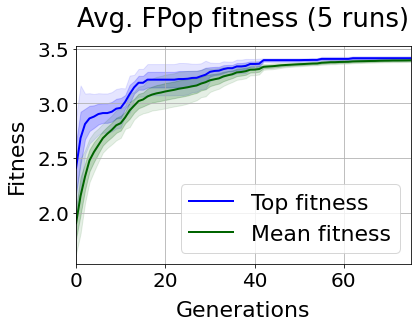

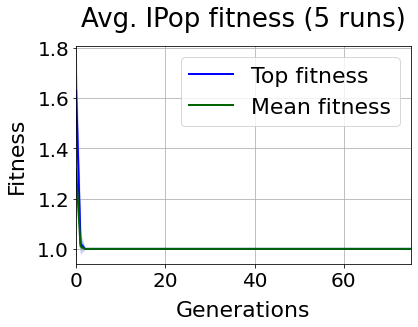

In [22]:
with open(f'results/lgp_baseline_elites.npz', 'rb') as f:
    npzfile = np.load(f)
    efs = npzfile['arr_0']
    
    for i, f in enumerate(fitnesses):
        ef_mean = np.mean(efs[:, i])
        ef_std = np.std(efs[:, i])
        print(f'{f.__name__}: {ef_mean} +- {ef_std}')

with open(f'results/lgp_baseline_metrics.npz', 'rb') as f:
    npzfile = np.load(f)
    ffs = npzfile['arr_0']
    ifs = npzfile['arr_1']
 
    plot_mean_and_top_feasible(ffs=ffs, exp_name='lgp_baseline')
    plot_mean_and_top_infeasible(ifs=ifs, exp_name='lgp_baseline')

box_filling_fitness: 0.8619653233058934 +- 0.06037192850714957
func_blocks_fitness: 0.05289330376442049 +- 0.020080919457201522
mame_fitness: 0.9694490867740718 +- 0.038099202776558726
mami_fitness: 0.9365943621571533 +- 0.09049796769247408


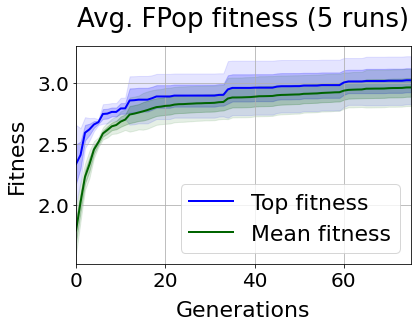

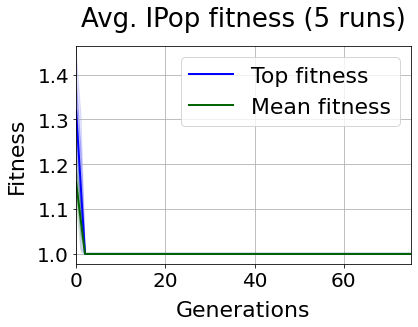

In [23]:
with open(f'results/hybrid_ea_elites.npz', 'rb') as f:
    npzfile = np.load(f)
    efs = npzfile['arr_0']
    
    for i, f in enumerate(fitnesses):
        ef_mean = np.mean(efs[:, i])
        ef_std = np.std(efs[:, i])
        print(f'{f.__name__}: {ef_mean} +- {ef_std}')

with open(f'results/hybrid_ea_metrics.npz', 'rb') as f:
    npzfile = np.load(f)
    ffs = npzfile['arr_0']
    ifs = npzfile['arr_1']
    
    plot_mean_and_top_feasible(ffs=ffs, exp_name='hybrid_ea')
    plot_mean_and_top_infeasible(ifs=ifs, exp_name='hybrid_ea')

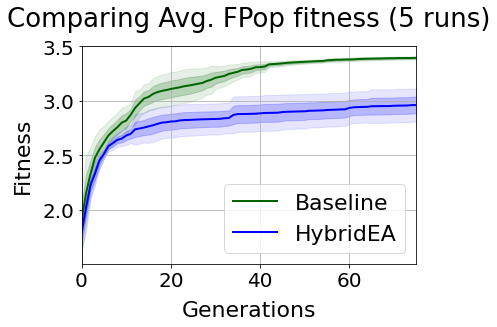

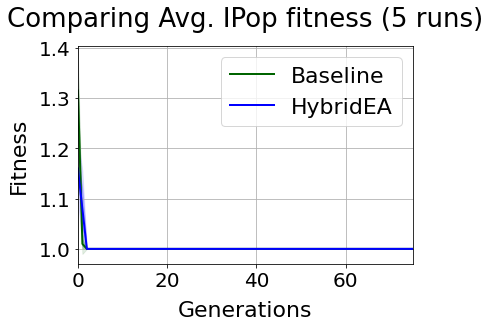

In [24]:
baseline_f = None
baseline_i = None
hybridea_f = None
hybridea_i = None

with open(f'results/lgp_baseline_metrics.npz', 'rb') as f:
    npzfile = np.load(f)
    baseline_f = npzfile['arr_0']
    baseline_i = npzfile['arr_1']

with open(f'results/hybrid_ea_metrics.npz', 'rb') as f:
    npzfile = np.load(f)
    hybridea_f = npzfile['arr_0']
    hybridea_i = npzfile['arr_1']

plot_mean_comparison(baseline=baseline_f,
                     hybridea=hybridea_f,
                     type_f='FPop')

plot_mean_comparison(baseline=baseline_i,
                     hybridea=hybridea_i,
                     type_f='IPop')